# Part III: Executing Queries

This notebook will show how we can start doing analysis on our data using the same SQL commands we would use in relational databases like Oracle and Postgres.

In additional to SQL, we can also use the pyspark api to help with our calculations.

In [0]:
#import packages
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark import SparkContext
from pyspark import Row

In [0]:
# build spark session
spark = SparkSession.builder.appName("Analyze Market Data").getOrCreate()

### Reminder from Part II
Remember in Part II we had to use the yfinance package to get our data and do some data cleanup. At the end we wrote our data to a delta table. Now all we have to do is run our spark.sql commands and we can instantly access the data!

This is a great way to keep notebooks focused and allow people who may not be data engineers the ability to access our processed data to perform analysis or share with other stakeholders.

In [0]:
# now we can execute our SQL query
details = spark.sql("SELECT * FROM details")
details.show()

+------+--------+------------+-----------+-----------+---------+--------------+-------------+
|symbol|    beta|totalRevenue|  totalDebt|overallRisk|auditRisk|exDividendDate|dividendYield|
+------+--------+------------+-----------+-----------+---------+--------------+-------------+
|  ORCL|0.995847| 47957999616|91810996224|         10|        8|    1681084800|       0.0168|
|   BLK|1.289273| 17417000960| 8488999936|          3|        4|    1678060800|       0.0297|
|   UNH| 0.67993|335943991296|70587998208|          3|       10|    1678406400|       0.0136|
+------+--------+------------+-----------+-----------+---------+--------------+-------------+



In [0]:
prices = spark.sql("SELECT * from prices")
prices.show(10)

+-------------------+------------------+------------------+------------------+------------------+------------------+--------+------+
|               Date|              Open|              High|               Low|             Close|          adjClose|  Volume|Symbol|
+-------------------+------------------+------------------+------------------+------------------+------------------+--------+------+
|2017-01-03 00:00:00| 38.45000076293945|38.689998626708984| 38.29999923706055| 38.54999923706055|34.786827087402344|11051300|  ORCL|
|2017-01-04 00:00:00| 38.54999923706055| 38.91999816894531| 38.54999923706055|  38.7400016784668| 34.95830154418945| 9545500|  ORCL|
|2017-01-05 00:00:00| 38.66999816894531| 38.95000076293945| 38.40999984741211| 38.63999938964844| 34.86805725097656|12064700|  ORCL|
|2017-01-06 00:00:00|             38.75|             38.75|38.380001068115234| 38.45000076293945|34.696598052978516|14829700|  ORCL|
|2017-01-09 00:00:00|38.529998779296875| 39.45000076293945|38.4700012

## Analyzing Our Data

Many times we only care about data in a certain time frame. This is especially true with financial data since time is an important consideration when making decisions. How an asset performed 10 years ago isn't necesarrily relevent to how it performs today.

Let's first look at some ways we can filter our data.

In [0]:
spark.sql("SELECT * FROM details WHERE dividendYield > 0.02").show()

+------+--------+------------+----------+-----------+---------+--------------+-------------+
|symbol|    beta|totalRevenue| totalDebt|overallRisk|auditRisk|exDividendDate|dividendYield|
+------+--------+------------+----------+-----------+---------+--------------+-------------+
|   BLK|1.289273| 17417000960|8488999936|          3|        4|    1678060800|       0.0297|
+------+--------+------------+----------+-----------+---------+--------------+-------------+



In [0]:
#we can also use the filter method
details.filter("dividendYield > 0.02").show()

+------+--------+------------+----------+-----------+---------+--------------+-------------+
|symbol|    beta|totalRevenue| totalDebt|overallRisk|auditRisk|exDividendDate|dividendYield|
+------+--------+------------+----------+-----------+---------+--------------+-------------+
|   BLK|1.289273| 17417000960|8488999936|          3|        4|    1678060800|       0.0297|
+------+--------+------------+----------+-----------+---------+--------------+-------------+



Great now let's perform a simple calculation. 

If we are building a portfolio using the three stocks in our data, we would want to know something about how risky our assets are. [Beta](https://www.investopedia.com/terms/b/beta.asp) is a measure of the volatity (or risk) of a stock. 

We are going to cacluate the Beta of our portfolio by taking the simple average Beta of the three assets.

*Note: In a real world scenario we would use the weighted average because our portoflio may not be equally weighted among assets*

In [0]:
spark.sql('SELECT AVG(beta) FROM details').show()

+---------+
|avg(beta)|
+---------+
|  0.98835|
+---------+



A beta of one means our portolio will move with the market. Since our beta is just under one we would expect slightly less volatitliy compared to the market.

Ok, now let's start to do some more complex calculations. 

We want to find how many days an asset closed at a price higher than its average price. Additionally, we are only concerned with data from the past year.

First let's get the average closing price for each asset.

To do this we will:
1. Filter the data to only get the prices in the last 12 months
2. Group by Symbol
3. Aggregate to get the mean closing price (Close column)

In [0]:
prev_year_avg_close = (
    spark.sql("SELECT * FROM prices WHERE Date > '2022-04-01' ")  # filter by date
    .groupby("Symbol")  # group by symbol
    .agg({"Close": "mean"})  # find the average closing price for each asset
    .withColumnRenamed("avg(Close)", "avgClose")  # rename column
)

prev_year_avg_close.show()

+------+-----------------+
|Symbol|         avgClose|
+------+-----------------+
|   BLK| 669.307877742883|
|   UNH|510.0001886541193|
|  ORCL|78.39439409429377|
+------+-----------------+



In [0]:
# now what if we need to get these values to use in another calculation
blk_avg_close = prev_year_avg_close.collect()[0][1]
print(f"Blackrock's avg closing price: ${blk_avg_close:.2f} in the last 12 months")

Blackstone's avg closing price: $669.31 in the last 12 months


Let's see now how many days Blackrock had a closing price that was above the average price by 5% for the year.

In [0]:
spark.sql(
    "SELECT COUNT(*) as daysAboveAvg "
    + "FROM prices WHERE Date > '2022-04-01' " # filter for data in the past year
    + "AND SYMBOL = 'BLK' AND Close >" # filter on BLK only 
    + str(blk_avg_close * 1.05) # add a 5% increase to the average closing price
).show()

+------------+
|daysAboveAvg|
+------------+
|          79|
+------------+



Great! Looks like the asset had a close price that was 5% above average 79 days last year. But 79 days doesn't really tell us much. Is 79 days good? Bad? 

A better way to convey the information captured here is with a percentage.

In [0]:
# Subquery to get the total number of rows we have
subquery = "(SELECT COUNT(*) as daysAboveAvg FROM prices WHERE Date > '2022-04-01' AND SYMBOL = 'BLK')"

# Execute our SQL query
spark.sql(
    "SELECT ROUND(COUNT(*) / "
    + subquery
    + " * 100,2) as PctAboveAvg "
    + "FROM prices WHERE Date > '2022-04-01' "
    + "AND SYMBOL = 'BLK' AND Close >"
    + str(blk_avg_close * 1.05)
).show()

+-----------+
|PctAboveAvg|
+-----------+
|      29.92|
+-----------+



Ok, looks like the stock finished with a closing price 5% higher than the average just under 30% of the time.

### Normalizing Data

If you remember from ealier in the notebook we looked at the average closing price. The data was across a very large range, with one asset having a price in the double digits and the other being in the hundreds. When comparing the trend of prices we would be smart to normalize our data first. To do this we can use the mean normailized value formula:

$$x_{norm} = \frac{x - \bar{x}}{ x_{max}-x_{min} }$$

We will create a temp view of this data as well so we can access is more readily.

In [0]:
# calculate xbar, xmax, and xmin
avg_close = prev_year_avg_close.agg({"avgClose": "avg"}).collect()[0][0]
max_close = prices.agg({"Close": "max"}).collect()[0][0]
min_close = prices.agg({"Close": "min"}).collect()[0][0]

print(f"X_bar: {avg_close} \nX_max: {max_close} \nX_min: {min_close}")

# formula
query = f"(Close - {avg_close}) / ({max_close - min_close})"

# execute query and create temp view
spark.sql(
    "SELECT Symbol, Date,  "
    + query
    + " as normClose FROM prices WHERE Date > '2022-04-01'"
).createOrReplaceTempView("normPrice")

X_bar: 419.2341534970987 
X_max: 971.489990234375 
X_min: 38.45000076293945


In [0]:
norm_price_df = spark.sql("SELECT * FROM normPrice").toPandas()
norm_price_df.head()

Let's create a quick visualization to set how our data looks.

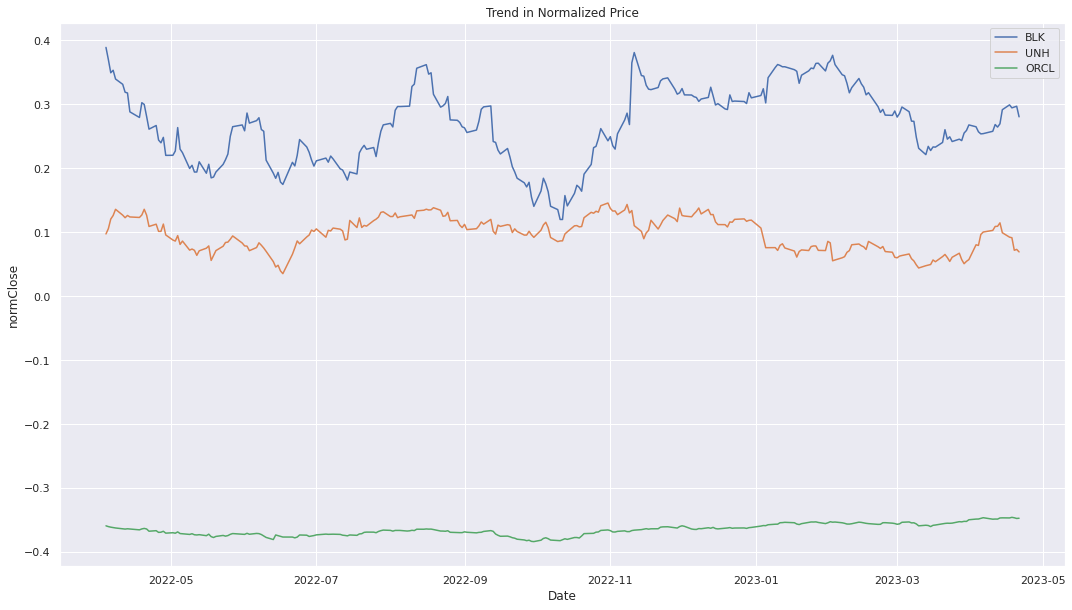

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(18,10))
sns.lineplot(data=norm_price_df, x='Date', y='normClose', hue = 'Symbol')
plt.legend(loc='best')
plt.title('Trend in Normalized Price')
sns.set_theme()

plt.show()

In [0]:
#Databricks allows easy visualization generation; this can only be seen from within Databracks.
# spark.sql("SELECT * FROM normPrice").display()

Nice! Databricks is great as it serves not only as a place to perform data processing and engineering tasks, but it also gives analysts a simple integrated enviroment to perform calculations and build visualizations straight from spark dataframes.